# GitHub analysis client
This notebook assumes that Pulsar is running and there are already partial results available

In [1]:
import matplotlib.pyplot as plt
import operator
import os
import pandas as pd
import sortedcontainers
from pulsar_wrapper import PulsarConnection

In [2]:
class LanguageTuple(object):
    """ Data Type to support tuple in-place sorting using sortedcontainers """
    def __init__(self, lang_tuple):
        self.lang = lang_tuple[0]
        self.value = lang_tuple[1]
        
    def __repr__(self):
        return f"('{self.lang}', {self.value})"

def sort_results(language_stats, field, num_results=None):
    lang_repos = sortedcontainers.SortedKeyList(key=lambda x: -x.value)
    for language in language_stats:
        lang_repos.add(LanguageTuple((language, language_stats[language][field])))
    return list(lang_repos[:num_results])

In [3]:
# Function to plot the results
def plot_result(result_tuple, title='', xlabel='', ylabel=''):
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)

    ax.set_ylabel(ylabel)
    ax.set_title(title)

    x_axis = [val.lang for val in result_tuple]
    y_axis = [val.value for val in result_tuple]
    plt.bar(range(len(result_tuple)), y_axis, tick_label=x_axis)
    plt.show()

In [4]:
# Take Pulsar host value from the environment variables
environment = os.environ
pulsar_host = environment.get("pulsar_host")
# If not set, assume its running in localhost
if (pulsar_host is None): pulsar_host = 'localhost'
my_pulsar = PulsarConnection(ip_address=pulsar_host)
language_stats = my_pulsar.get_languages_stats()

2022-06-01 20:16:54.191 INFO  [139804485240640] ClientConnection:189 | [<none> -> pulsar://localhost:6650] Create ClientConnection, timeout=10000
2022-06-01 20:16:54.193 INFO  [139804485240640] ConnectionPool:96 | Created connection for pulsar://localhost:6650
2022-06-01 20:16:54.197 INFO  [139803533190912] ClientConnection:375 | [127.0.0.1:37628 -> 127.0.0.1:6650] Connected to broker
2022-06-01 20:16:54.208 INFO  [139803533190912] HandlerBase:64 | [persistent://public/static/initialized, reader-0dc92ef975, 0] Getting connection from pool
2022-06-01 20:16:54.213 INFO  [139803533190912] ConsumerImpl:224 | [persistent://public/static/initialized, reader-0dc92ef975, 0] Created consumer on broker [127.0.0.1:37628 -> 127.0.0.1:6650] 
Found 'Initializing' message
Found 'Initialized' message
2022-06-01 20:16:54.220 INFO  [139804485240640] ConsumerImpl:999 | [persistent://public/static/initialized, reader-0dc92ef975, 0] Closing consumer for topic persistent://public/static/initialized
2022-06-

In [5]:
# While we get real data, populate with test data num_tests and num_ci
import random
for language in language_stats:
    language_stats[language]['num_tests'] = random.randint(1,100)
    language_stats[language]['num_ci'] = random.randint(1,language_stats[language]['num_tests'])

# 1. Top programming languages based on the number of projects developed

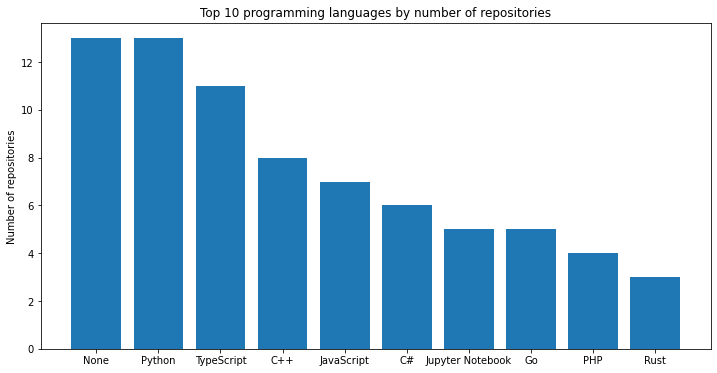

In [6]:
# Define the number of top languages to return, get the results, and plot them
num_results = 10
lang_repos = sort_results(language_stats, 'num_repos', num_results)
plot_result(lang_repos, 
          title=f'Top {len(lang_repos)} programming languages by number of repositories', 
          xlabel='', ylabel='Number of repositories')

# 2. Repositories with most commits

In [7]:
# Receives tuples in format (id_repo, num_commits, 'repo_owner', 'repo_name')
#top_repos = my_pulsar.get_top_commits(10)
# Test data meanwhile
top_repos = [
    (4, 16, 'owner_1', 'repo_1'),
    (5, 21, 'owner_2', 'repo_2'),
    (6, 26, 'owner_3', 'repo_3')]
results=[]
for repo in top_repos:
    repo_name = f"{repo[2]}/{repo[3]}"
    results.append((repo_name, repo[1]))

In [8]:
pd.DataFrame(results, columns=['Repository name','Number of commits'])

,Repository name,Number of commits
0,owner_1/repo_1,16
1,owner_2/repo_2,21
2,owner_3/repo_3,26


# 3. Top languages with testdriven approach

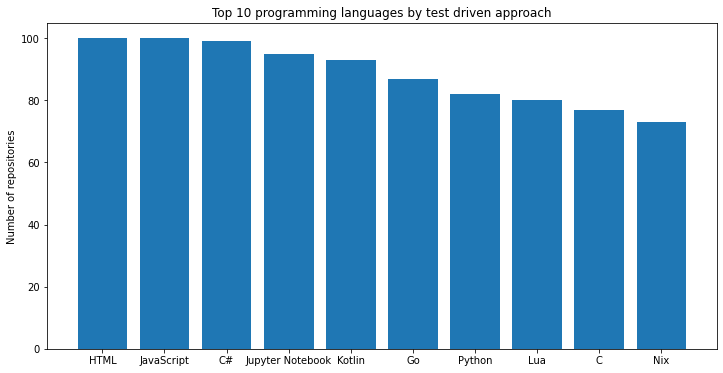

In [9]:
# Define the number of top languages to return, get the results, and plot them
num_results_test = 10
lang_repos_test = sort_results(language_stats, 'num_tests', num_results_test)
plot_result(lang_repos_test, 
          title=f'Top {len(lang_repos_test)} programming languages by test driven approach', 
          xlabel='', ylabel='Number of repositories')

# 4. Top languages with testdriven approach and continous integration

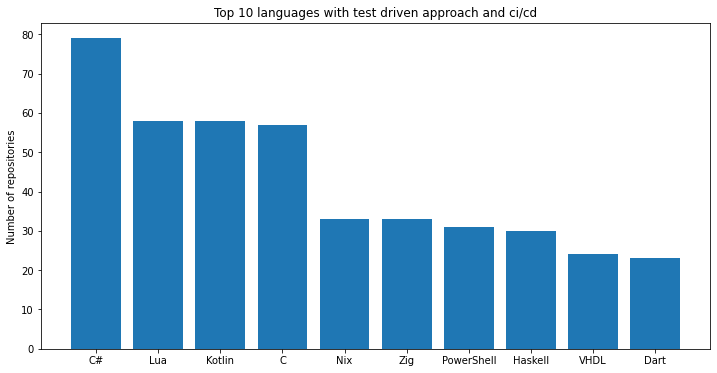

In [10]:
# Define the number of top languages to return, get the results, and plot them
num_results_ci = 10
lang_repos_ci = sort_results(language_stats, 'num_ci', num_results_ci)
plot_result(lang_repos_ci, 
          title=f'Top {len(lang_repos_ci)} languages with test driven approach and ci/cd', 
          xlabel='', ylabel='Number of repositories')

In [11]:
my_pulsar.close()

2022-06-01 20:17:37.266 INFO  [139804485240640] ClientImpl:496 | Closing Pulsar client with 0 producers and 2 consumers
2022-06-01 20:17:37.269 INFO  [139804485240640] ClientConnection:1559 | [127.0.0.1:37628 -> 127.0.0.1:6650] Connection closed
2022-06-01 20:17:37.269 INFO  [139804485240640] ClientConnection:263 | [127.0.0.1:37628 -> 127.0.0.1:6650] Destroyed connection
